In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Available shot types: ['drive', 'sweep', 'pullshot', 'legglance-flick']

Image counts per class:
drive     : 1224
sweep     : 1120
pullshot  : 1260
legglance-flick: 1120


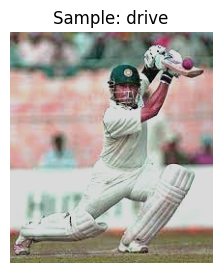

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# ✅ Path to your dataset
base_path = "/content/drive/MyDrive/CricVision/Shots"

# List all shot types (subfolders)
shot_types = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
print(f"Available shot types: {shot_types}\n")

# Count number of images per class
image_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in shot_types}
print("Image counts per class:")
for cls, count in image_counts.items():
    print(f"{cls:<10}: {count}")

# Display one sample per class
for cls in shot_types:
    cls_path = os.path.join(base_path, cls)
    sample_img = os.listdir(cls_path)[0]
    img_path = os.path.join(cls_path, sample_img)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(3,3))
    plt.imshow(img_rgb)
    plt.title(f"Sample: {cls}")
    plt.axis('off')
    plt.show()
    break  # remove break to preview all shot categories


In [ ]:
import pandas as pd

data = []

for cls in shot_types:
    cls_path = os.path.join(base_path, cls)
    for file in os.listdir(cls_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            data.append({
                "filename": file,
                "filepath": os.path.join(cls_path, file),
                "label": cls
            })

df = pd.DataFrame(data)
print(f"Total images: {len(df)}")
df.head(10)


Total images: 4723


,filename,filepath,label
0,drives165.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
1,drives194.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
2,drives1206.jpeg,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
3,drives146.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
4,drives200.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
5,drives2.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
6,drives151.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
7,drives14.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
8,drives126.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive
9,drives1150.png,/content/drive/MyDrive/CricVision/Shots/drive/...,drive


No charts were generated by quickchart


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ✅ Normalize labels (replace '-' with '_')
df['label'] = df['label'].str.replace('-', '_')

# Train-test split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(train_df['label'].value_counts())

# Image size for EfficientNet
IMG_SIZE = (224, 224)

# Data loading functions
def preprocess_image(path, label):
    img = tf.io.read_file(path)

    # Decode image safely
    img = tf.image.decode_jpeg(img, channels=3)  # force JPEG/PNG decode
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize and normalize
    img = tf.image.resize(img, IMG_SIZE)
    return img, label

# TensorFlow datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (tf.data.Dataset.from_tensor_slices((train_df['filepath'].values, train_df['label'].values))
            .map(preprocess_image, num_parallel_calls=AUTOTUNE)
            .shuffle(1000)
            .batch(32)
            .prefetch(AUTOTUNE))

val_ds = (tf.data.Dataset.from_tensor_slices((val_df['filepath'].values, val_df['label'].values))
          .map(preprocess_image, num_parallel_calls=AUTOTUNE)
          .batch(32)
          .prefetch(AUTOTUNE))


Training samples: 3778
Validation samples: 945
label
pullshot           1008
drive               978
sweep               896
legglance_flick     896
Name: count, dtype: int64


In [ ]:
import os
from sklearn.preprocessing import LabelEncoder
import joblib

# ✅ Create subfolder if it doesn’t exist
save_dir = "/content/drive/MyDrive/CricVision/shot_classification"
os.makedirs(save_dir, exist_ok=True)

# Encode labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Save metadata and encoder
metadata_path = os.path.join(save_dir, "processed_shots_metadata.csv")
encoder_path = os.path.join(save_dir, "label_encoder.pkl")

df.to_csv(metadata_path, index=False)
joblib.dump(le, encoder_path)

print("✅ All artifacts saved successfully!")
print(f"Metadata CSV: {metadata_path}")
print(f"Label Encoder: {encoder_path}")

# Show label mapping for reference
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nLabel Encoding Map:")
for k, v in label_map.items():
    print(f"{k:<18} -> {v}")


✅ All artifacts saved successfully!
Metadata CSV: /content/drive/MyDrive/CricVision/shot_classification/processed_shots_metadata.csv
Label Encoder: /content/drive/MyDrive/CricVision/shot_classification/label_encoder.pkl

Label Encoding Map:
drive              -> 0
legglance_flick    -> 1
pullshot           -> 2
sweep              -> 3


Running extended EDA checks...


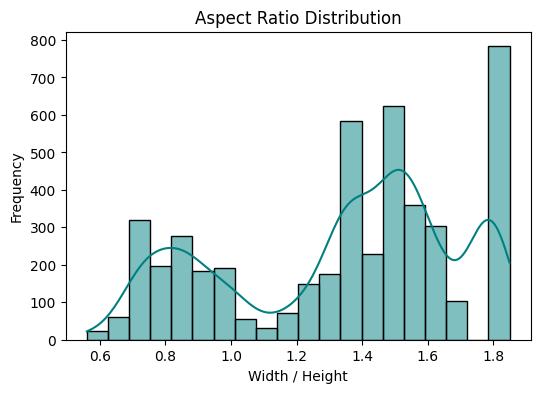

Computing brightness (this may take a minute)...


/tmp/ipython-input-3413364539.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='brightness', data=df, palette='viridis')


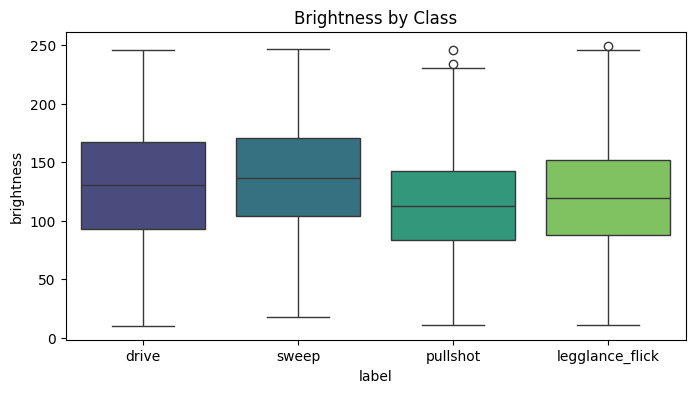

Sampling color stats from 100 random images...


100%|██████████| 100/100 [00:01<00:00, 58.05it/s]


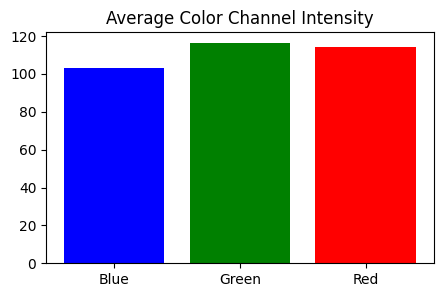

Visualizing random augmentations...


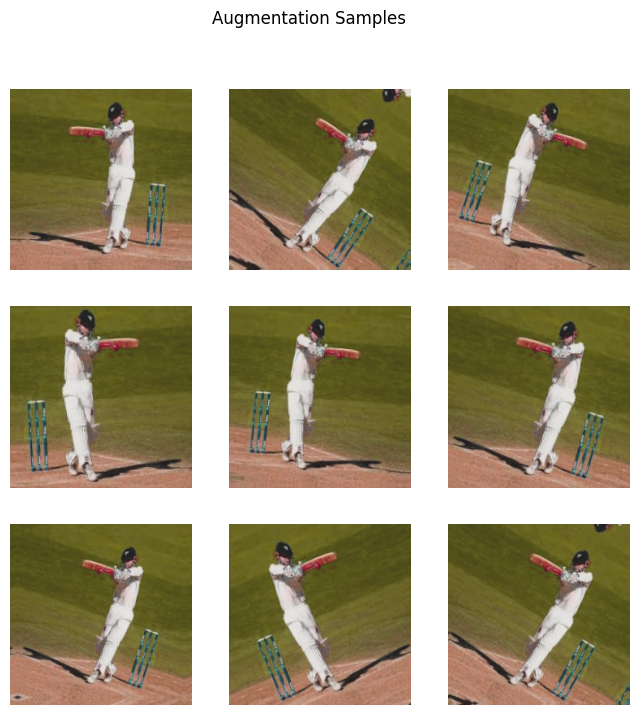

Generating low-dimensional embeddings for 200 samples...


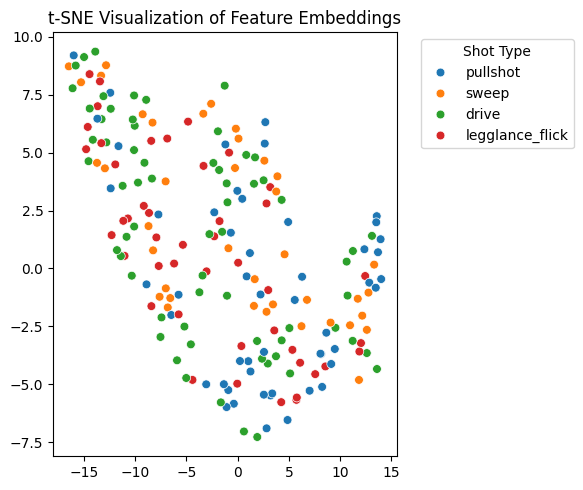


Extended EDA complete — dataset verified and consistent for training.


In [ ]:
# ============================================================
# EXTENDED EDA VALIDATION — CricVision Shot Classification
# ============================================================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.applications import EfficientNetB0
from sklearn.manifold import TSNE
from tqdm import tqdm

print("Running extended EDA checks...")

# ---------------------------------------------
# 1. Image Aspect Ratio Distribution
# ---------------------------------------------
df['width'], df['height'] = zip(*df['filepath'].apply(lambda p: Image.open(p).size))
df['aspect_ratio'] = df['width'] / df['height']

plt.figure(figsize=(6,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True, color='teal')
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------------
# 2. Brightness Distribution per Class
# ---------------------------------------------
def get_brightness(path):
    img = np.array(Image.open(path).convert("L"))
    return img.mean()

print("Computing brightness (this may take a minute)...")
df['brightness'] = df['filepath'].apply(get_brightness)

plt.figure(figsize=(8,4))
sns.boxplot(x='label', y='brightness', data=df, palette='viridis')
plt.title("Brightness by Class")
plt.show()

# ---------------------------------------------
# 3. Color Channel Mean Distribution
# ---------------------------------------------
print("Sampling color stats from 100 random images...")
sample_paths = df['filepath'].sample(min(100, len(df)), random_state=42)
means = []
for path in tqdm(sample_paths):
    img = cv2.imread(path)
    if img is not None:
        means.append(img.mean(axis=(0,1)))
means = np.array(means)
plt.figure(figsize=(5,3))
plt.bar(['Blue', 'Green', 'Red'], means.mean(axis=0), color=['blue','green','red'])
plt.title("Average Color Channel Intensity")
plt.show()

# ---------------------------------------------
# 4. Augmentation Preview
# ---------------------------------------------
print("Visualizing random augmentations...")
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

rand_img_path = df['filepath'].sample(1, random_state=42).iloc[0]
img = tf.keras.utils.load_img(rand_img_path, target_size=(224,224))
img = tf.keras.utils.img_to_array(img) / 255.0

plt.figure(figsize=(8, 8))
for i in range(9):
    aug_img = data_augmentation(tf.expand_dims(img, 0))
    plt.subplot(3, 3, i+1)
    plt.imshow(aug_img[0])
    plt.axis("off")
plt.suptitle("Augmentation Samples", fontsize=12)
plt.show()

# ---------------------------------------------
# 5. Quick Visual Separability Check (t-SNE)
# ---------------------------------------------
print("Generating low-dimensional embeddings for 200 samples...")
subset_df = df.sample(min(200, len(df)), random_state=42)
model = EfficientNetB0(include_top=False, pooling='avg', weights='imagenet')

# Convert embeddings list to numpy array before TSNE
embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)

plt.figure(figsize=(6,5))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=labels, palette='tab10', s=40)
plt.title("t-SNE Visualization of Feature Embeddings")
plt.legend(title="Shot Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("\nExtended EDA complete — dataset verified and consistent for training.")
